In [2]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [3]:
!nvidia-smi

Thu Apr 11 20:51:11 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 460, done.
remote: Counting objects: 100% (191/191), done.
remote: Compressing objects: 100% (100/100), done.
remote: Total 460 (delta 131), reused 124 (delta 91), pack-reused 269
Receiving objects: 100% (460/460), 126.19 KiB | 936.00 KiB/s, done.
Resolving deltas: 100% (233/233), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 1.1 MB/s eta 0:00:00
***********************************************************************
Woo! Your instance has a Tesla T4 GPU!
We will install the latest stable RAPIDS via pip 24.2.*!  Please stand by, should be quick...
***********************************************************************

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 464.7/464.7 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 GB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 GB 1.

In [5]:
import cuml
cuml.__version__

'24.02.00'

### Load Libraries

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.spatial import distance_matrix
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from cuml.naive_bayes import GaussianNB
from cuml.model_selection import GridSearchCV

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load Dataset

In [32]:
data = pd.read_csv("/content/drive/MyDrive/reduced_data.csv", delimiter=";")

data['quality'].value_counts().sort_index()

4    180
5    180
7    180
8    180
Name: quality, dtype: int64

## Outlier Detection and Marking

### Outlier boxplots

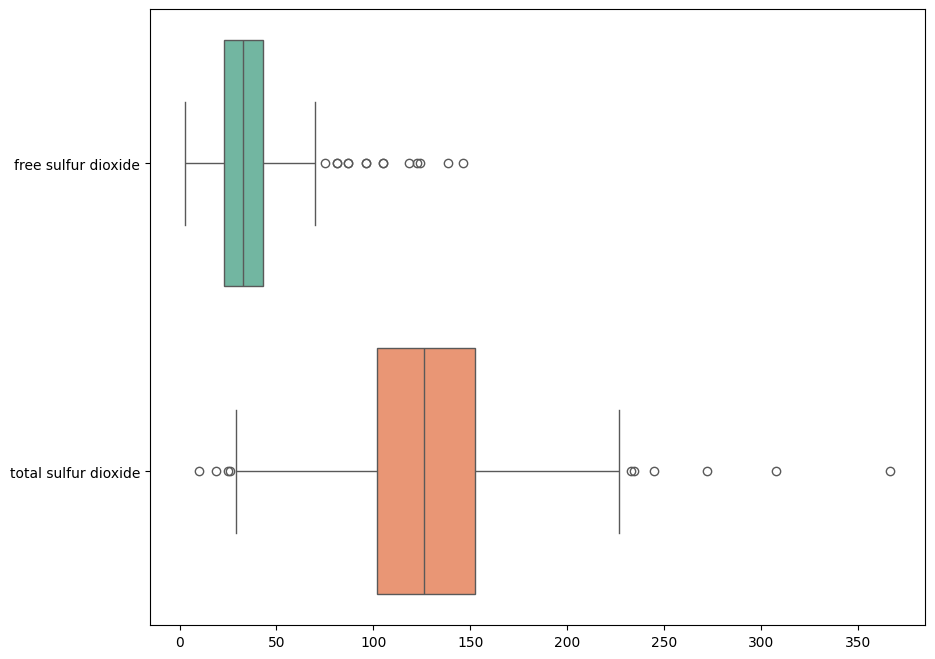

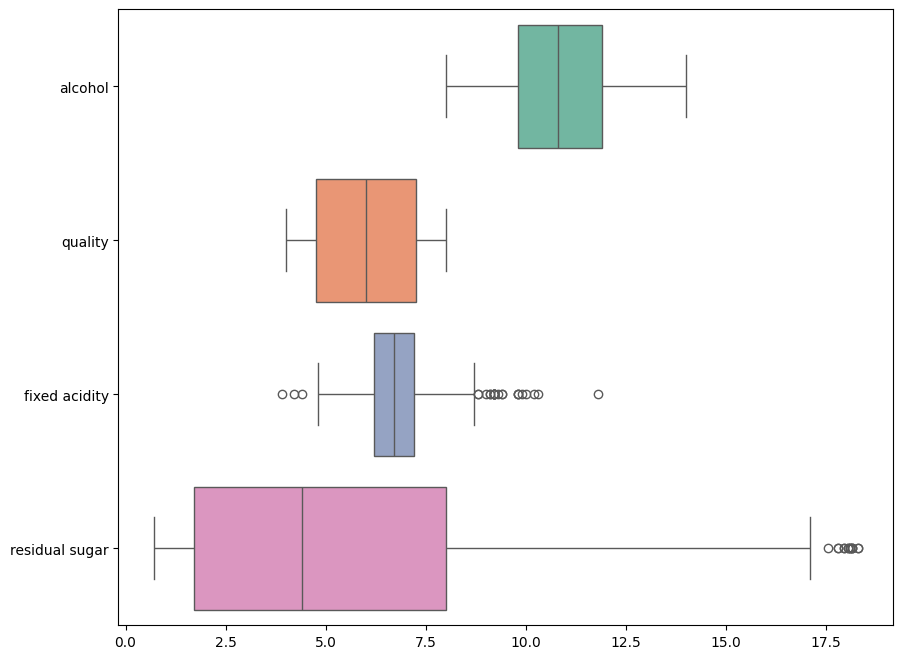

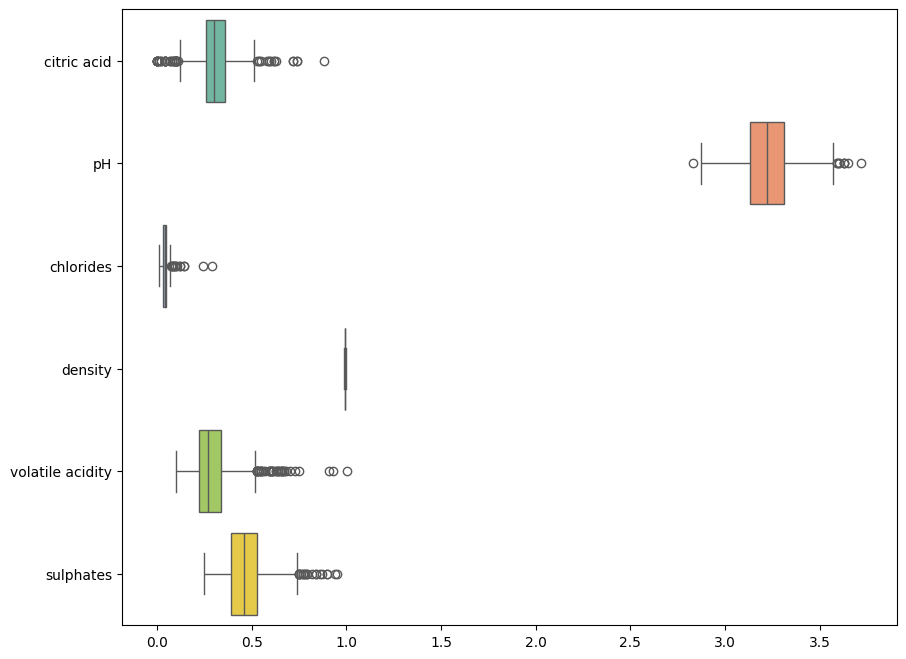

In [33]:
def plot_boxplot(df, columns):
    plt.figure(figsize=(10, 8))
    sns.boxplot(data=df[columns], orient="h", palette="Set2")
    plt.show()

boxplot_data = reduced_data.copy()

# Boxplots
column_list = list(boxplot_data.columns)
chosen_columns = ['free sulfur dioxide', 'total sulfur dioxide']
if not chosen_columns:
    chosen_columns = list(boxplot_data.columns)
    plot_boxplot(boxplot_data, chosen_columns)
else:
    plot_boxplot(boxplot_data, chosen_columns)
    chosen_columns2 = ['alcohol', 'quality', 'fixed acidity', 'residual sugar']
    plot_boxplot(boxplot_data, chosen_columns2)
    column_list = list(set(column_list) - set(chosen_columns) - set(chosen_columns2))
    plot_boxplot(boxplot_data, column_list)

### Outlier marking and statistics

In [34]:
def remove_outliers(df, columns):
    outlier_counts = {} # Dictionary to store outlier counts
    outlier_indices = pd.Index([]) # Empty index to store outliers
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        is_outlier = ~((df[column] >= (Q1 - 1.5 * IQR)) & (df[column] <= (Q3 + 1.5 * IQR)))
        outlier_counts[column] = is_outlier.sum()  # Count outliers for the column
        outlier_indices = outlier_indices.union(df[is_outlier].index)

    # Remove outliers at once
    df_clean = df.drop(index=outlier_indices)
    return df_clean, outlier_counts, outlier_indices

clean_data = reduced_data.copy()

clean_data, outlier_counts, outlier_indices = remove_outliers(clean_data, list(clean_data.columns))

outlier_indices = reduced_data.index.difference(clean_data.index)
reduced_data['outlier'] = 0
reduced_data.loc[outlier_indices, 'outlier'] = 1

print(f"{'Column':<30} {'Count':<10} {'Percentage'}")
for column in clean_data.columns:
    count = outlier_counts.get(column, 0)
    percentage = (count / len(reduced_data)) * 100
    print(f"{column:<30} {count:<10} {percentage:.2f}%")

outlier_distribution = reduced_data['outlier'].value_counts()

display(outlier_distribution)

Column                         Count      Percentage
fixed acidity                  26         3.61%
volatile acidity               42         5.83%
citric acid                    48         6.67%
residual sugar                 15         2.08%
chlorides                      15         2.08%
free sulfur dioxide            14         1.94%
total sulfur dioxide           10         1.39%
density                        0          0.00%
pH                             10         1.39%
sulphates                      20         2.78%
alcohol                        0          0.00%
quality                        0          0.00%


0    559
1    161
Name: outlier, dtype: int64

### Outlier column check

In [35]:
reduced_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,outlier
0,8.3,0.27,0.45,1.3,0.048,8.0,72.0,0.99440,3.08,0.61,10.3,4,0
1,8.2,0.26,0.44,1.3,0.046,7.0,69.0,0.99440,3.14,0.62,10.2,4,0
2,9.2,0.19,0.42,2.0,0.047,16.0,104.0,0.99517,3.09,0.66,10.0,4,1
3,9.4,0.29,0.55,2.2,0.050,17.0,119.0,0.99620,3.12,0.69,10.3,4,1
4,8.4,0.19,0.42,1.6,0.047,9.0,101.0,0.99400,3.06,0.65,11.1,4,0


## Change quality to binary, scale data and perform Train, Test, Val split

In [43]:
# Drop the 'outlier' column and replace 'quality' values with binary labels
wines_data = reduced_data.drop(['outlier'], axis=1)
wines_data['quality'] = wines_data['quality'].replace({4: 0, 5: 0, 7: 1, 8: 1})

# Separate features and target variable
features = wines_data.drop('quality', axis=1)
target = wines_data['quality']

# Split the data into train, validation, and test sets
# Training set is 70% of the original data
# Validation set is 15% of the original data
# Test set is 15% of the original data
X_train_val, X_test, y_train_val, y_test = train_test_split(features, target, test_size=0.15, random_state=1, stratify=target)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.176, random_state=1, stratify=y_train_val)

# Print the distribution of the target variable in different datasets
print("Original data distribution:")
display(target.value_counts().sort_index())
print("Training set distribution:")
display(y_train.value_counts().sort_index())
print("Validation set distribution:")
display(y_val.value_counts().sort_index())
print("Test set distribution:")
display(y_test.value_counts().sort_index())

# Scale the features using Min-Max scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Retain appropriate index from original data for future outlier analysis
train_indices = X_train.index
val_indices = X_val.index
test_indices = X_test.index

# Convert the scaled features back to DataFrames with appropriate indices
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=train_indices)
X_val = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=val_indices)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=test_indices)

X_val_with_outliers = reduced_data.loc[val_indices, 'outlier']
X_test_with_outliers = reduced_data.loc[test_indices, 'outlier']


Original data distribution:


0    360
1    360
Name: quality, dtype: int64

Training set distribution:


0    252
1    252
Name: quality, dtype: int64

Validation set distribution:


0    54
1    54
Name: quality, dtype: int64

Test set distribution:


0    54
1    54
Name: quality, dtype: int64

## Gaussian naive bayes

#### Train Gaussian naive bayes Classifier and Calculate Confusion Matrix and Metrics

Validation Accuracy: 0.8333333333333334
Validation Precision: 0.7903225806451613
Validation Recall: 0.9074074074074074
Validation F1 Score: 0.8448275862068966
Confusion matrix (Validation):
 [[41 13]
 [ 5 49]]


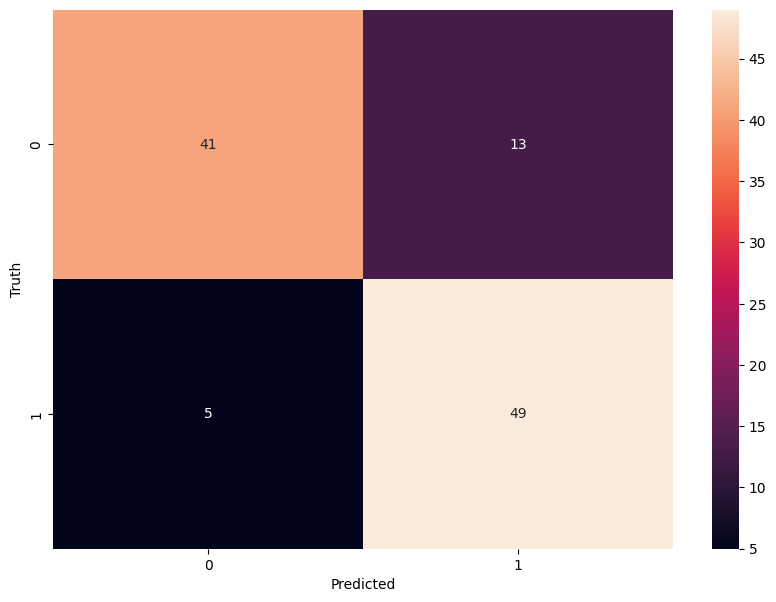

In [44]:
# Ensure data types are compatible
X_train = np.array(X_train).astype(np.float32)
y_train = np.array(y_train).astype(np.int32)
X_val = np.array(X_val).astype(np.float32)
y_val = np.array(y_val).astype(np.int32)

# Initialize the Gaussian Naive Bayes classifier
gnb = GaussianNB()

# Train the classifier
gnb.fit(X_train, y_train)

# Make predictions on the validation set
y_val_pred = gnb.predict(X_val)

# Evaluate the model on the validation set
accuracy_val = accuracy_score(y_val, y_val_pred)
precision_val = precision_score(y_val, y_val_pred)
recall_val = recall_score(y_val, y_val_pred)
f1_val = f1_score(y_val, y_val_pred)

# Display evaluation metrics for the validation set
print(f"Validation Accuracy: {accuracy_val}")
print(f"Validation Precision: {precision_val}")
print(f"Validation Recall: {recall_val}")
print(f"Validation F1 Score: {f1_val}")

# Generate and display confusion matrix for the validation set
cm_val = confusion_matrix(y_val, y_val_pred)
print("Confusion matrix (Validation):\n", cm_val)

plt.figure(figsize=(10,7))
sns.heatmap(cm_val, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

### Find best parameters


In [45]:
gnb = GaussianNB()

# Define the parameter grid for the grid search
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5],
}

# Initialize the GridSearchCV with Gaussian Naive Bayes estimator
grid_search = GridSearchCV(estimator=gnb, param_grid=param_grid, cv=5, scoring='f1', verbose=3, refit=False)

# Perform the grid search on the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Display the results in a DataFrame
results = pd.DataFrame(grid_search.cv_results_)
results = results.sort_values(by='mean_test_score', ascending=False)
top_results = results[['param_var_smoothing', 'mean_test_score']].head()
print(top_results)

# Show results indicating that parameters do not make a significant difference

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ...............var_smoothing=1e-09;, score=0.871 total time=   0.0s
[CV 2/5] END ...............var_smoothing=1e-09;, score=0.830 total time=   0.0s
[CV 3/5] END ...............var_smoothing=1e-09;, score=0.862 total time=   0.0s
[CV 4/5] END ...............var_smoothing=1e-09;, score=0.855 total time=   0.0s
[CV 5/5] END ...............var_smoothing=1e-09;, score=0.825 total time=   0.0s
[CV 1/5] END ...............var_smoothing=1e-08;, score=0.871 total time=   0.0s
[CV 2/5] END ...............var_smoothing=1e-08;, score=0.830 total time=   0.0s
[CV 3/5] END ...............var_smoothing=1e-08;, score=0.862 total time=   0.0s
[CV 4/5] END ...............var_smoothing=1e-08;, score=0.855 total time=   0.0s
[CV 5/5] END ...............var_smoothing=1e-08;, score=0.825 total time=   0.0s
[CV 1/5] END ...............var_smoothing=1e-07;, score=0.871 total time=   0.0s
[CV 2/5] END ...............var_smoothing=1e-07;,

### Calculate metrics for new model With best parameter var smoothing

Validation Accuracy: 0.8333333333333334
Validation Precision: 0.7903225806451613
Validation Recall: 0.9074074074074074
Validation F1 Score: 0.8448275862068966
Confusion matrix (Validation):
 [[41 13]
 [ 5 49]]


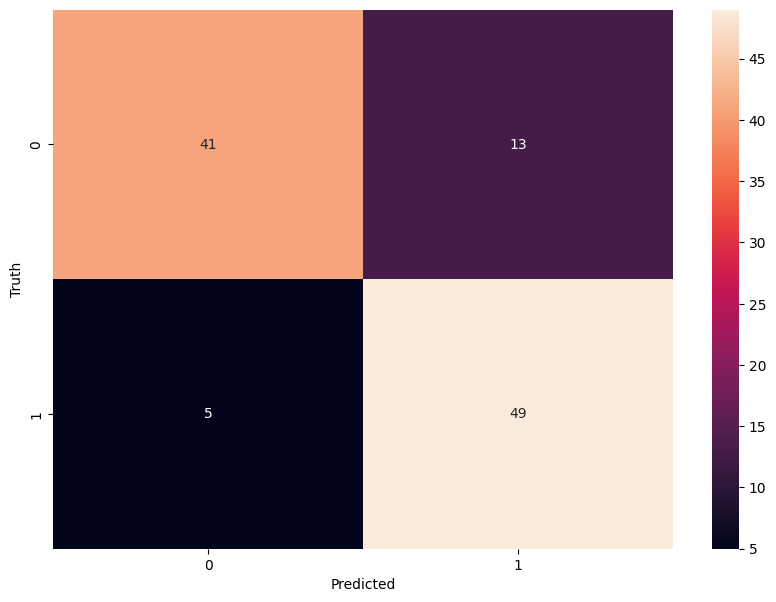

In [46]:
# Initialize the Gaussian Naive Bayes classifier
best_model_GNB = GaussianNB(var_smoothing=1e-9)
best_model_GNB.fit(X_train, y_train)

# Make predictions on the validation set
y_val_pred = best_model_GNB.predict(X_val)

# Evaluate the model on the validation set
accuracy_val = accuracy_score(y_val, y_val_pred)
precision_val = precision_score(y_val, y_val_pred)
recall_val = recall_score(y_val, y_val_pred)
f1_val = f1_score(y_val, y_val_pred)

# Display evaluation metrics for the validation set
print(f"Validation Accuracy: {accuracy_val}")
print(f"Validation Precision: {precision_val}")
print(f"Validation Recall: {recall_val}")
print(f"Validation F1 Score: {f1_val}")

# Generate and display confusion matrix for the validation set
cm_val = confusion_matrix(y_val, y_val_pred)
print("Confusion matrix (Validation):\n", cm_val)

plt.figure(figsize=(10, 7))
sns.heatmap(cm_val, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

# Show results indicating that parameters do not make a significant difference

### Vizualization of validation using Tsne

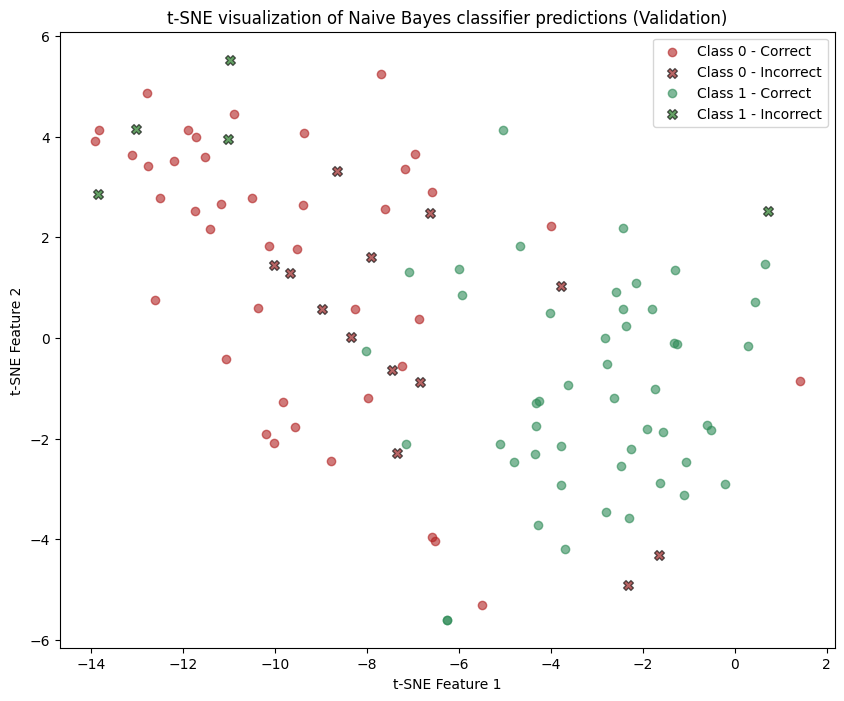

In [47]:
tsne = TSNE(n_components=2, random_state=1, perplexity=30, n_iter=2000, learning_rate=80)
X_val_2d = tsne.fit_transform(X_val)

correctly_classified = y_val == y_val_pred
incorrectly_classified = ~correctly_classified

plt.figure(figsize=(10, 8))

# Correctly classified of class 0
plt.scatter(X_val_2d[(y_val == 0) & correctly_classified, 0],
            X_val_2d[(y_val == 0) & correctly_classified, 1],
            marker='o', color='firebrick', alpha=0.6, label='Class 0 - Correct')

# Incorrectly classified of class 0
plt.scatter(X_val_2d[(y_val == 0) & incorrectly_classified, 0],
            X_val_2d[(y_val == 0) & incorrectly_classified, 1],
            marker='X', color='darkred', alpha=0.6, s=50, edgecolor='black', label='Class 0 - Incorrect')

# Correctly classified of class 1
plt.scatter(X_val_2d[(y_val == 1) & correctly_classified, 0],
            X_val_2d[(y_val == 1) & correctly_classified, 1],
            marker='o', color='seagreen', alpha=0.6, label='Class 1 - Correct')

# Incorrectly classified of class 1
plt.scatter(X_val_2d[(y_val == 1) & incorrectly_classified, 0],
            X_val_2d[(y_val == 1) & incorrectly_classified, 1],
            marker='X', color='darkgreen', alpha=0.6, s=50, edgecolor='black', label='Class 1 - Incorrect')

plt.title('t-SNE visualization of Naive Bayes classifier predictions (Validation)')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.legend(loc='best')
plt.show()

### Test data

Test Accuracy: 0.8518518518518519
Test Precision: 0.7878787878787878
Test Recall: 0.9629629629629629
Test F1 Score: 0.8666666666666665
Confusion matrix:
 [[40 14]
 [ 2 52]]


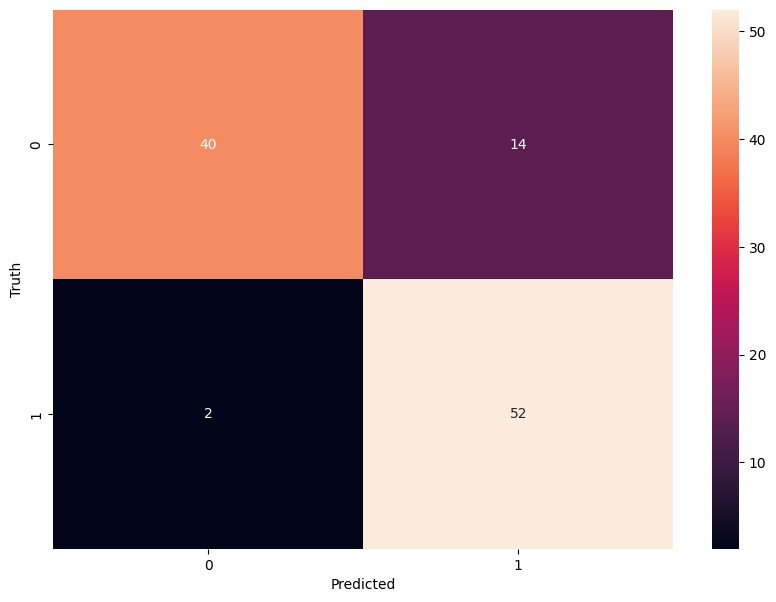

In [48]:
# Convert X_test to a NumPy array with float32 dtype
X_test_np = np.array(X_test).astype(np.float32)

# Convert y_test to a NumPy array with int32 dtype
y_test_np = np.array(y_test).astype(np.int32)

# Make predictions on the test set
y_test_pred = best_model_GNB.predict(X_test_np)

# Evaluate the best model on the test set
accuracy_test = accuracy_score(y_test_np, y_test_pred)
precision_test = precision_score(y_test_np, y_test_pred)
recall_test = recall_score(y_test_np, y_test_pred)
f1_test = f1_score(y_test_np, y_test_pred)

# Display evaluation metrics for the test set
print(f"Test Accuracy: {accuracy_test}")
print(f"Test Precision: {precision_test}")
print(f"Test Recall: {recall_test}")
print(f"Test F1 Score: {f1_test}")

# Generate and display confusion matrix for the test set
cm_test = confusion_matrix(y_test_np, y_test_pred)

print("Confusion matrix:\n", cm_test)

plt.figure(figsize=(10,7))
sns.heatmap(cm_test, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()


### Visualization of test predictions

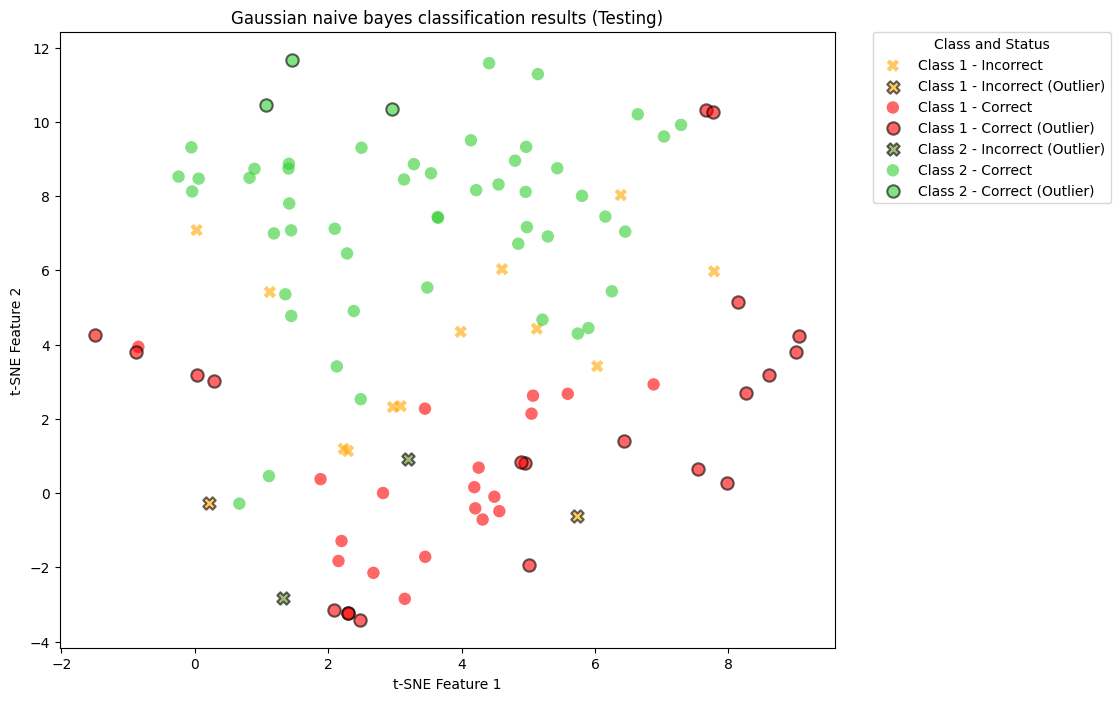

In [49]:
# Initialize and fit t-SNE for 2D visualization
tsne = TSNE(n_components=2, random_state=1, perplexity=30, n_iter=2000, learning_rate=80)
X_test_2d = tsne.fit_transform(X_test)

# Separate correctly and incorrectly classified samples
correctly_classified = y_test == y_test_pred
incorrectly_classified = ~correctly_classified

# Create DataFrame for test data with 2D t-SNE representation
test_data = pd.DataFrame(X_test_2d, columns=['TSNE1', 'TSNE2'], index=test_indices)
test_data['Correct Classification'] = correctly_classified
test_data['Outlier'] = X_test_with_outliers
test_data['Class'] = y_test

# Define color and marker mappings
color_map = {
    ('0', True): 'red',         # Class 0 and correctly classified
    ('0', False): 'orange',     # Class 0 and incorrectly classified
    ('1', True): 'limegreen',   # Class 1 and correctly classified
    ('1', False): 'olivedrab'   # Class 1 and incorrectly classified
}

markers = {True: 'o', False: 'X'}  # 'o' for correct, 'X' for incorrect

# Define marker sizes for outliers and normal samples
outlier_marker_size = 80
outlier_edge_color = 'black'
normal_marker_size = 80

# Plot test data with t-SNE visualization
plt.figure(figsize=(10, 8))

for (cls, correct), group_data in test_data.groupby(['Class', 'Correct Classification']):
    sns.scatterplot(data=group_data[group_data['Outlier'] == 0], x='TSNE1', y='TSNE2',
                    color=color_map[(str(cls), correct)], marker=markers[correct],
                    label=f'Class {cls+1} - {"Correct" if correct else "Incorrect"}',
                    alpha=0.6, s=normal_marker_size, edgecolor='none')

    if not group_data[group_data['Outlier'] == 1].empty:
        sns.scatterplot(data=group_data[group_data['Outlier'] == 1], x='TSNE1', y='TSNE2',
                        color=color_map[(str(cls), correct)], marker=markers[correct],
                        alpha=0.6, s=outlier_marker_size, edgecolor=outlier_edge_color, linewidth=1.5,
                        label=f'Class {cls+1} - {"Correct" if correct else "Incorrect"} (Outlier)')

plt.title('Gaussian naive bayes classification results (Testing)')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.legend(title='Class and Status', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
